# 만들어진 FastText model을 통한 감정분석 실시
> * Positive or Negative

In [1]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys
import os

os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import pandas as pd

from gensim.models import FastText, KeyedVectors
from gensim.models.doc2vec import TaggedDocument

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE

import keras.backend.tensorflow_backend as K
from keras.preprocessing import sequence
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Embedding, embeddings, merge, Dropout, Activation,  LSTM, Bidirectional, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.utils import np_utils
from tensorflow.python.client import device_lib
from keras.layers.merge import dot


import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

C:\Users\pc\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9837849008324904223
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4984510873
locality {
  bus_id: 1
}
incarnation: 13761594217045549717
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


In [3]:
def Make_Roc_Curve(x, y, model1, model2, model3, model4):
    print ('Logistic Regression')
    fpr1, tpr1, thresholds1 = roc_curve(y, model1.predict(x))
    print ('Random Forest')
    fpr2, tpr2, thresholds2 = roc_curve(y, model2.predict(x))
    print ('Kernel SVM')
    fpr3, tpr3, thresholds3 = roc_curve(y, model3.predict(x))
    print ('XGBoost')
    import xgboost as xgb
    fpr4, tpr4, thresholds4 = roc_curve(y, model4.predict(xgb.DMatrix(x)))
    plt.plot(fpr1, tpr1, label="Logistic Regression")
    plt.plot(fpr2, tpr2, label="RandomForest")
    plt.plot(fpr3, tpr3, label="Kernel SVM")
    plt.plot(fpr4, tpr4, label='XGBoost')
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

In [4]:
def plot_history(history):
    """Plot model history after `fit()`.
    """

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [5]:
def Make_TSNE1(n_component, model, wv, limit):
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas(desc="progress-bar")
    wv = wv[:limit]
    tsne_model = TSNE(n_components=n_component,
                       verbose = 1, random_state = 0)
    tsne_w2v = tsne_model.fit_transform(wv)
    tsne_df = pd.DataFrame(tsne_w2v, columns = ['x', 'y'])
    tsne_df['words'] = list(model.wv.vocab.keys())[:limit]
    i = 0
    for i in tqdm(range(tsne_df['words'].size)):
        plt.scatter(tsne_df['x'][i], tsne_df['y'][i])
        plt.annotate(tsne_df['words'][i], 
                xy = (tsne_df['x'][i], tsne_df['y'][i]))
    plt.show()

In [6]:
def Make_TSNE2(n_component, model, wv, limit):
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import pandas as pd
    from tqdm import tqdm
    import bokeh.plotting as bp
    from bokeh.models import HoverTool, BoxSelectTool
    from bokeh.plotting import figure, show, output_notebook
    
    output_notebook()
    plot_tfidf = bp.figure(plot_width=500, plot_height=500, title="A map of word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

    word_vectors = [model[w] for w in tqdm(list(model.wv.vocab.keys())[:limit])]

    tsne_model = TSNE(n_components=n_component, verbose=1, random_state=0)
    tsne_w2v = tsne_model.fit_transform(word_vectors)
    # putting everything in a dataframe
    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = list(model.wv.vocab.keys())[:limit]

    # plotting. the corresponding word appears when you hover on the data point.
    plot_tfidf.scatter(x='x', y='y', source=tsne_df)
    hover = plot_tfidf.select(dict(type=HoverTool))
    hover.tooltips={"word": "@words"}
    show(plot_tfidf)

In [7]:
def Build_tfidf(data):
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(analyzer = lambda x: x, min_df = 2)
    matrix = vectorizer.fit_transform([x.words for x in tqdm(data)])
    print (matrix.shape)
    tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    print ('vocab size : {}'.format(len(tfidf)))    
    return tfidf

In [8]:
def buildWordVector(tokens, model, size, tfidf):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [9]:
def Make_Pre_Data(model, tfidf, size, train, test):
    from datetime import datetime
    start = datetime.now()
    print (str(model))
    wv = [model[w] for w in tqdm(model.wv.vocab.keys())]
    process1 = datetime.now()
    print ('running time : {}'.format(process1 - start))
    
    print ('Vectorizing Train Data')
    train_vecs_w2v = np.concatenate([buildWordVector(z, model, size, tfidf) for z in tqdm(map(lambda x: x.words, train))])
    print ('scaling Train Data')
    train_vecs_w2v = scale(train_vecs_w2v)
    process2 = datetime.now()
    print ('running time : {}'.format(process2 - process1))
    
    print ('Vectorizing Test Data')
    test_vecs_w2v = np.concatenate([buildWordVector(z, model, size, tfidf) for z in tqdm(map(lambda x: x.words, test))])
    print ('scaling Test Data')
    test_vecs_w2v = scale(test_vecs_w2v)
    process3 = datetime.now()
    print ('running time : {}'.format(process3 - process2))
    
    print ('total running time : {}'.format(process3 - start))
    return wv, train_vecs_w2v, test_vecs_w2v

In [10]:
if sys.platform =='darwin':
    loadModelPath = '/Volumes/disk1/model/'
    #loadModelPath = './model/'
elif sys.platform =='win32':
    loadModelPath = 'd:/model/'
saveTrainPath = './data/pre_data/train_test_Data2/'
saveClassifierPath = './data/pre_data/classifier/'

In [11]:
def ReMake_Outcome(train_y, test_y):
    from tqdm import tqdm
    tqdm.pandas(desc="progress-bar") 
    train_y = [y[0] for y in tqdm(train_y)]
    test_y = [y[0] for y in tqdm(test_y)]
    return train_y, test_y

In [12]:
def Return_ModelName(model, tagger):
    size = model.vector_size
    epochs = model.epochs
    window = model.window
    negative = model.negative 
    hs = model.hs 
    sg = model.sg 
    cbow_mean = model.cbow_mean 
    min_count = model.min_count 
    min_alpha = model.min_alpha
    alpha = model.alpha
    modelName = 'fastText_size-{}_epochs-{}_window-{}_negative-{}_hs-{}_sg-{}_cbow_mean-{}_min_count-{}_min_alpha-{}_alpha-{}_by-{}'.format(
    size, epochs, window, negative, hs, sg, cbow_mean, min_count, 
    min_alpha, alpha, tagger)
    return modelName

In [13]:
cores = int(multiprocessing.cpu_count())
print (cores)

12


In [14]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags sentiment')

## Twitter

###  Load FastText model을 만들기 위해 사용한 사용된 train set

In [15]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_data_train_for_fastText_sentiment_by_ct.pickled','rb'))
y_train = np.array([doc.sentiment for doc in tqdm(train)])

100%|██████████| 442359/442359 [00:00<00:00, 1446397.53it/s]


### train set을 사용하여 Tf-Idf vectorizer을 만듦

In [16]:
tfidf = Build_tfidf(train)

100%|██████████| 442359/442359 [00:00<00:00, 1534433.70it/s]


(442359, 159010)
vocab size : 159010


### Load FastText model을 만들기 위해 사용한 사용된 testset

In [17]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_data_test_for_fastText_sentiment_by_ct.pickled','rb'))
y_test = np.array([doc.sentiment for doc in tqdm(test)])

100%|██████████| 49151/49151 [00:00<00:00, 1240928.65it/s]


In [18]:
train_y2, test_y2 = ReMake_Outcome(y_train, y_test)

100%|██████████| 49151/49151 [00:00<00:00, 1043660.39it/s]


### Model_1

In [19]:
print ('Load Model1')
model1 = FastText.load(loadModelPath+'fastText_size-1000_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-0_cbow_mean-0_min_count-2_by-ct.model')

Load Model1
Load Model2
Load Model3


In [20]:
wv1, train_vecs_w2v, test_vecs_w2v = Make_Pre_Data(model1, tfidf, 1000, train, test)
modelName = Return_ModelName(model1,'ct')

FastText(vocab=162564, size=1000, alpha=0.025)


  0%|          | 0/162564 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 162564/162564 [00:08<00:00, 18537.82it/s]


running time : 0:00:12.808954
Vectorizing Train Data


0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
442359it [24:59, 295.05it/s]


scaling Train Data



49151it [05:50, 140.04it/s]


scaling Test Data
running time : 0:06:16.764006
total running time : 0:36:28.443566


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  if __name__ == '__main__':


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [21]:
%%time
Make_TSNE2(2, model1, wv1, 10000)

Loading BokehJS ...

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
100%|██████████| 10000/10000 [00:00<00:00, 64834.47it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.653s...
[t-SNE] Computed neighbors for 10000 samples in 163.296s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.185317
[t-SNE] KL divergence after 250 iterations with early exaggeration: 128.337814
[t-SNE] Error after 1000 iterations: 3.600833


Wall time: 8min 50s


#### 분류모델 : Logistic Regression

In [22]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.7940631930174361
classification report
             precision    recall  f1-score   support

          0       0.78      0.83      0.81     25314
          1       0.81      0.76      0.78     23837

avg / total       0.79      0.79      0.79     49151

Wall time: 8min 20s


#### 분류모델 : Random Forest

In [23]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.7508901141380643
classification report
             precision    recall  f1-score   support

          0       0.76      0.75      0.76     25314
          1       0.74      0.75      0.75     23837

avg / total       0.75      0.75      0.75     49151

Wall time: 4min 44s


#### 분류모델 : C - Support Vector Classification

In [24]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_vecs_w2v)
train_vecs_w2v2 = scaling.transform(train_vecs_w2v)
test_vecs_w2v2 = scaling.transform(test_vecs_w2v)
classifier3 =  SVC(kernel = 'linear',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v2)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.49006123985269884
classification report
             precision    recall  f1-score   support

          0       0.79      0.01      0.03     25314
          1       0.49      1.00      0.65     23837

avg / total       0.64      0.49      0.33     49151

Wall time: 20min 9s


#### 분류모델 : XGBOOST

In [25]:
max_depth = 5
subsample = 0.7
colsample_bytree= 0.7
params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
    'eta':0.125,
    'nthread' : cores
    
    }
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

In [26]:
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [27]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
print (accuracy_score(y_test, test_class))
print (classification_report(y_test, test_class))
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-auc:0.659366	eval-auc:0.650551
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.684678	eval-auc:0.676943
[2]	train-auc:0.702812	eval-auc:0.694563
[3]	train-auc:0.713849	eval-auc:0.704542
[4]	train-auc:0.723047	eval-auc:0.712986
[5]	train-auc:0.731503	eval-auc:0.721189
[6]	train-auc:0.73648	eval-auc:0.725075
[7]	train-auc:0.743639	eval-auc:0.73143
[8]	train-auc:0.749564	eval-auc:0.737299
[9]	train-auc:0.755666	eval-auc:0.743253
[10]	train-auc:0.760382	eval-auc:0.747302
[11]	train-auc:0.765265	eval-auc:0.752189
[12]	train-auc:0.769095	eval-auc:0.755578
[13]	train-auc:0.772788	eval-auc:0.759477
[14]	train-auc:0.775104	eval-auc:0.761976
[15]	train-auc:0.778315	eval-auc:0.765216
[16]	train-auc:0.781465	eval-auc:0.767985
[17]	train-auc:0.784688	eval-auc:0.771369
[18]	train-auc:0.787264	eval-auc:0.773354
[19]	train-auc:0.789308	eval-auc:0.775434
[20]	train-auc:0.791371	eval-au

Logistic Regression
Random Forest
Kernel SVM
XGBoost


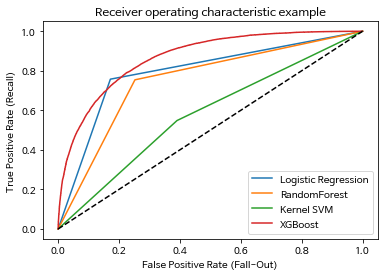

Wall time: 2min 13s


In [28]:
%%time
Make_Roc_Curve(test_vecs_w2v, y_test, classifier, classifier2, classifier3, gbm)

In [29]:
del classifier
del classifier2
del classifier3
del gbm

## Neural Network

In [30]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4759
Accuracy: 0.8036


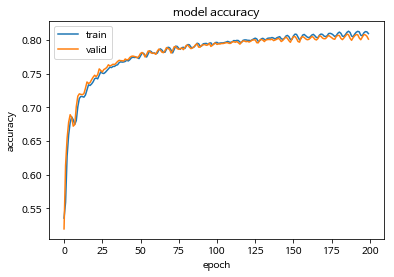

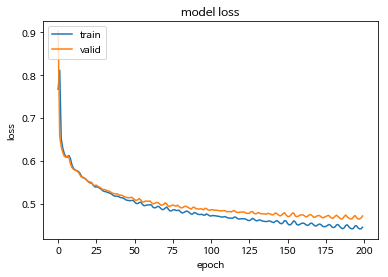

In [31]:
plot_history(history)

In [32]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4780
Accuracy: 0.8053


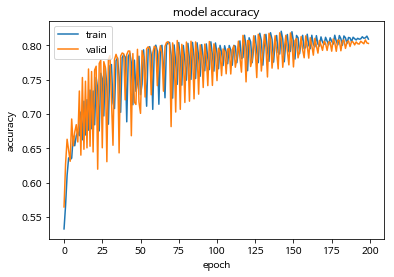

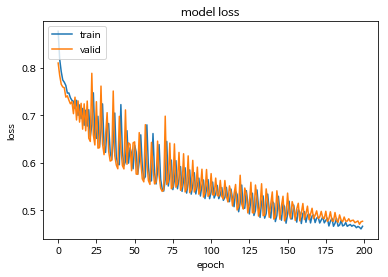

In [33]:
plot_history(history)

In [ ]:
del model1
del wv1
del train_vecs_w2v
del test_vecs_w2v

### Model_2

In [ ]:
print ('Load Model2')
model2 = FastText.load(loadModelPath+'fastText_size-1000_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-0_cbow_mean-1_min_count-2_by-ct.model')

In [20]:
wv1, train_vecs_w2v, test_vecs_w2v = Make_Pre_Data(model2, tfidf, 1000, train, test)
modelName = Return_ModelName(model2,'ct')

FastText(vocab=162564, size=1000, alpha=0.025)


  0%|          | 0/162564 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 162564/162564 [00:08<00:00, 20214.86it/s]


running time : 0:00:13.801982
Vectorizing Train Data


0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
442359it [24:28, 301.25it/s]


scaling Train Data
running time : 1:30:58.355879
Vectorizing Test Data


49151it [06:16, 130.56it/s]


scaling Test Data
running time : 0:06:22.184328
total running time : 1:37:34.342189


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  if __name__ == '__main__':


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [35]:
%%time
Make_TSNE2(2, model2, wv1, 10000)

Loading BokehJS ...

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
100%|██████████| 10000/10000 [00:00<00:00, 59394.26it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.705s...
[t-SNE] Computed neighbors for 10000 samples in 164.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.313382
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.975548
[t-SNE] Error after 1000 iterations: 2.596791


Wall time: 7min 50s


#### 분류모델 : Logistic Regression

In [21]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8177453154564506
classification report
             precision    recall  f1-score   support

          0       0.82      0.84      0.83     25314
          1       0.82      0.80      0.81     23837

avg / total       0.82      0.82      0.82     49151

Wall time: 10min 38s


#### 분류모델 : Random Forest

In [22]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8035238347134341
classification report
             precision    recall  f1-score   support

          0       0.81      0.80      0.81     25314
          1       0.79      0.80      0.80     23837

avg / total       0.80      0.80      0.80     49151

Wall time: 5min 10s


#### 분류모델 : C - Support Vector Classification

In [23]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_vecs_w2v)
train_vecs_w2v2 = scaling.transform(train_vecs_w2v)
test_vecs_w2v2 = scaling.transform(test_vecs_w2v)
classifier3 =  SVC(kernel = 'linear',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v2)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.4926044231043112
classification report
             precision    recall  f1-score   support

          0       0.76      0.02      0.04     25314
          1       0.49      0.99      0.65     23837

avg / total       0.63      0.49      0.34     49151

Wall time: 22min 53s


#### 분류모델 : XGBOOST

In [24]:
max_depth = 5
subsample = 0.7
colsample_bytree= 0.7
params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
    'eta':0.125,
    'nthread' : cores
    
    }
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

In [25]:
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [26]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
print (accuracy_score(y_test, test_class))
print (classification_report(y_test, test_class))
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-auc:0.729036	eval-auc:0.7242
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.763011	eval-auc:0.757889
[2]	train-auc:0.786125	eval-auc:0.781719
[3]	train-auc:0.797473	eval-auc:0.792464
[4]	train-auc:0.802184	eval-auc:0.796778
[5]	train-auc:0.808531	eval-auc:0.802692
[6]	train-auc:0.813815	eval-auc:0.808111
[7]	train-auc:0.817936	eval-auc:0.812104
[8]	train-auc:0.820698	eval-auc:0.814822
[9]	train-auc:0.824917	eval-auc:0.819218
[10]	train-auc:0.827804	eval-auc:0.821815
[11]	train-auc:0.830421	eval-auc:0.824265
[12]	train-auc:0.834496	eval-auc:0.828335
[13]	train-auc:0.83719	eval-auc:0.830932
[14]	train-auc:0.839596	eval-auc:0.833295
[15]	train-auc:0.842557	eval-auc:0.83599
[16]	train-auc:0.844789	eval-auc:0.838057
[17]	train-auc:0.846538	eval-auc:0.839486
[18]	train-auc:0.848806	eval-auc:0.84167
[19]	train-auc:0.850346	eval-auc:0.843162
[20]	train-auc:0.852374	eval-auc:0

Logistic Regression
Random Forest
Kernel SVM
XGBoost


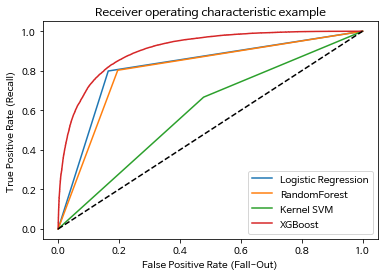

Wall time: 2min 28s


In [27]:
%%time
Make_Roc_Curve(test_vecs_w2v, y_test, classifier, classifier2, classifier3, gbm)

In [28]:
del classifier
del classifier2
del classifier3
del gbm

## Neural Network

In [29]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4079
Accuracy: 0.8321


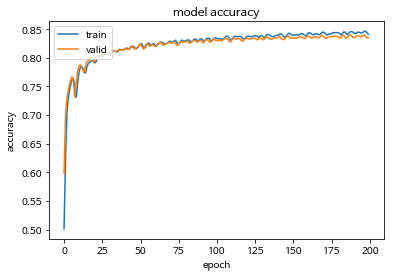

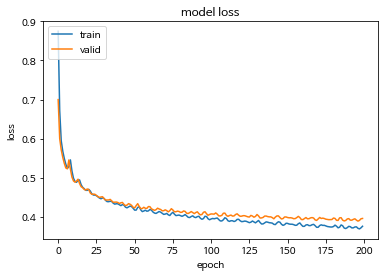

In [30]:
plot_history(history)

In [31]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4125
Accuracy: 0.8396


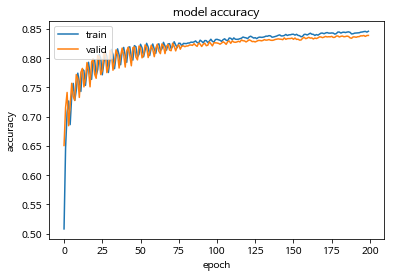

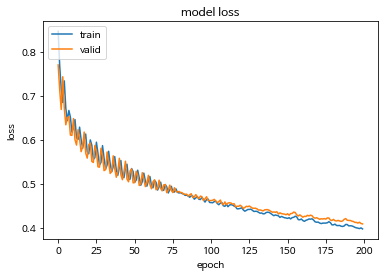

In [32]:
plot_history(history)

In [ ]:
del model2
del wv1
del train_vecs_w2v
del test_vecs_w2v

### Model_3

In [19]:
print ('Load Model3')
model3 = FastText.load(loadModelPath+'fastText_size-1000_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-1_cbow_mean-0_min_count-2_by-ct.model')

Load Model3


In [20]:
wv1, train_vecs_w2v, test_vecs_w2v = Make_Pre_Data(model3, tfidf, 1000, train, test)
modelName = Return_ModelName(model3,'ct')

FastText(vocab=162564, size=1000, alpha=0.025)


  0%|          | 0/162564 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 162564/162564 [00:01<00:00, 110259.03it/s]


running time : 0:00:01.479895
Vectorizing Train Data


0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
442359it [14:33, 506.24it/s]


scaling Train Data
running time : 0:16:12.124810
Vectorizing Test Data


49151it [03:19, 246.57it/s]


scaling Test Data
running time : 0:03:20.934457
total running time : 0:19:34.539162


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  if __name__ == '__main__':


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [34]:
%%time
Make_TSNE2(2, model3, wv1, 10000)

Loading BokehJS ...

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
100%|██████████| 10000/10000 [00:00<00:00, 66561.99it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.859s...
[t-SNE] Computed neighbors for 10000 samples in 162.813s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.255041
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.840515
[t-SNE] Error after 1000 iterations: 2.827481


Wall time: 8min 56s


#### 분류모델 : Logistic Regression

In [26]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.829525340277919
classification report
             precision    recall  f1-score   support

          0       0.83      0.84      0.84     25314
          1       0.83      0.81      0.82     23837

avg / total       0.83      0.83      0.83     49151

Wall time: 1h 29min 59s


#### 분류모델 : Random Forest

In [27]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8056194177127627
classification report
             precision    recall  f1-score   support

          0       0.82      0.80      0.81     25314
          1       0.79      0.81      0.80     23837

avg / total       0.81      0.81      0.81     49151

Wall time: 5min 21s


#### 분류모델 : C - Support Vector Classification

In [28]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_vecs_w2v)
train_vecs_w2v2 = scaling.transform(train_vecs_w2v)
test_vecs_w2v2 = scaling.transform(test_vecs_w2v)
classifier3 =  SVC(kernel = 'linear',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v2)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.49240096844418224
classification report
             precision    recall  f1-score   support

          0       0.70      0.03      0.05     25314
          1       0.49      0.99      0.65     23837

avg / total       0.60      0.49      0.34     49151

Wall time: 24min 18s


#### 분류모델 : XGBOOST

In [21]:
max_depth = 5
subsample = 0.7
colsample_bytree= 0.7
params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
    'eta':0.125,
    'nthread' : cores
    
    }
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

In [22]:
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [23]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
print (accuracy_score(y_test, test_class))
print (classification_report(y_test, test_class))
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-auc:0.711723	eval-auc:0.710328
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.735082	eval-auc:0.733386
[2]	train-auc:0.755291	eval-auc:0.752379
[3]	train-auc:0.767439	eval-auc:0.764427
[4]	train-auc:0.783087	eval-auc:0.778122
[5]	train-auc:0.795367	eval-auc:0.790093
[6]	train-auc:0.802968	eval-auc:0.796889
[7]	train-auc:0.808614	eval-auc:0.802361
[8]	train-auc:0.814042	eval-auc:0.80769
[9]	train-auc:0.819068	eval-auc:0.813014
[10]	train-auc:0.822292	eval-auc:0.816182
[11]	train-auc:0.826604	eval-auc:0.820494
[12]	train-auc:0.830023	eval-auc:0.823984
[13]	train-auc:0.833421	eval-auc:0.827538
[14]	train-auc:0.836323	eval-auc:0.830228
[15]	train-auc:0.838924	eval-auc:0.832569
[16]	train-auc:0.841166	eval-auc:0.834401
[17]	train-auc:0.843804	eval-auc:0.837027
[18]	train-auc:0.846021	eval-auc:0.839215
[19]	train-auc:0.847684	eval-auc:0.840749
[20]	train-auc:0.849422	eval-a

[191]	train-auc:0.928173	eval-auc:0.911364
[192]	train-auc:0.928334	eval-auc:0.911471
[193]	train-auc:0.928505	eval-auc:0.911588
[194]	train-auc:0.928651	eval-auc:0.911703
[195]	train-auc:0.928809	eval-auc:0.911805
[196]	train-auc:0.928943	eval-auc:0.911884
[197]	train-auc:0.929098	eval-auc:0.912026
[198]	train-auc:0.929221	eval-auc:0.912073
[199]	train-auc:0.92936	eval-auc:0.912158
0.8316412687432606
             precision    recall  f1-score   support

          0       0.84      0.83      0.84     25314
          1       0.82      0.83      0.83     23837

avg / total       0.83      0.83      0.83     49151



Logistic Regression
Random Forest
Kernel SVM
XGBoost


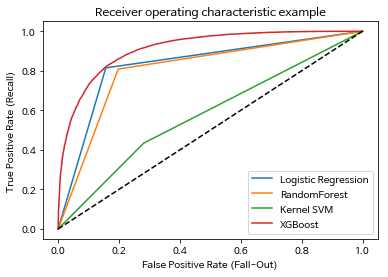

Wall time: 1min 58s


In [29]:
%%time
Make_Roc_Curve(test_vecs_w2v, y_test, classifier, classifier2, classifier3, gbm)

In [30]:
del classifier
del classifier2
del classifier3
del gbm

## Neural Network

In [31]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.3726
Accuracy: 0.8511


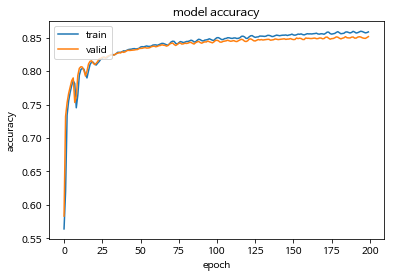

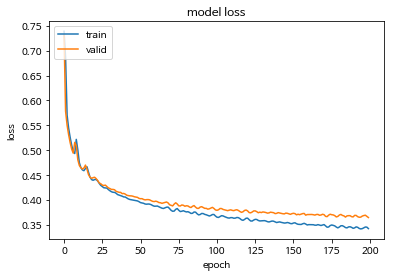

In [32]:
plot_history(history)

In [33]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.3930
Accuracy: 0.8499


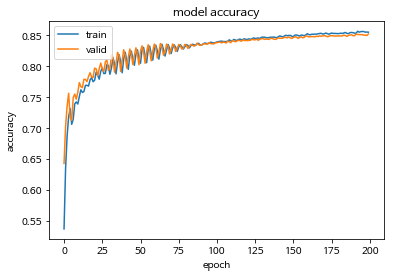

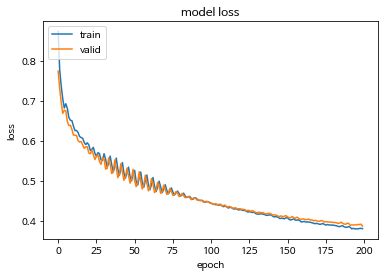

In [34]:
plot_history(history)

In [35]:
del model3
del wv1
del train_vecs_w2v
del test_vecs_w2v

## Mecab

###  Load fastText model을 만들기 위해 사용한 사용된 train set

In [17]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_data_train_for_fastText_sentiment_by_mecab.pickled','rb'))
y_train = np.array([doc.sentiment for doc in tqdm(train)])

100%|██████████| 442359/442359 [00:00<00:00, 994086.62it/s] 


### train set을 사용하여 Tf-Idf vectorizer을 만듦

In [18]:
tfidf = Build_tfidf(train)

100%|██████████| 442359/442359 [00:00<00:00, 1543424.91it/s]


(442359, 162003)
vocab size : 162003


### Load fastText model을 만들기 위해 사용한 사용된 testset

In [19]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_data_test_for_fastText_sentiment_by_mecab.pickled','rb'))
y_test = np.array([doc.sentiment for doc in tqdm(test)])

100%|██████████| 49151/49151 [00:00<00:00, 1326398.99it/s]


In [20]:
train_y2, test_y2 = ReMake_Outcome(y_train, y_test)

100%|██████████| 49151/49151 [00:00<00:00, 1022423.09it/s]


### Model_1 

In [20]:
print ('Load Model1')
model1 = FastText.load(loadModelPath+'fastText_size-1000_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-0_cbow_mean-0_min_count-2_by-mecab.model')

Load Model1


In [21]:
wv1, train_vecs_w2v, test_vecs_w2v = Make_Pre_Data(model1, tfidf, 1000, train, test)
modelName = Return_ModelName(model1,'mecab')

FastText(vocab=165823, size=1000, alpha=0.025)


  0%|          | 0/165823 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 165823/165823 [00:01<00:00, 119462.31it/s]


running time : 0:00:01.412118
Vectorizing Train Data


0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
442359it [16:05, 458.10it/s]


scaling Train Data
running time : 0:30:42.653110
Vectorizing Test Data


49151it [04:06, 199.02it/s]


scaling Test Data
running time : 0:04:09.713579
total running time : 0:34:53.778807


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  if __name__ == '__main__':


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [44]:
%%time
Make_TSNE2(2, model1, wv1, 10000)

Loading BokehJS ...

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
100%|██████████| 10000/10000 [00:00<00:00, 80777.75it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.735s...
[t-SNE] Computed neighbors for 10000 samples in 163.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.200531
[t-SNE] KL divergence after 250 iterations with early exaggeration: 121.629288
[t-SNE] Error after 1000 iterations: 3.456165


Wall time: 8min 38s


#### 분류모델 : Logistic Regression

In [45]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.7989257593945189
classification report
             precision    recall  f1-score   support

          0       0.80      0.82      0.81     25350
          1       0.80      0.78      0.79     23801

avg / total       0.80      0.80      0.80     49151

Wall time: 22min 18s


#### 분류모델 : Random Forest

In [46]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.7581534455046692
classification report
             precision    recall  f1-score   support

          0       0.77      0.76      0.76     25350
          1       0.75      0.76      0.75     23801

avg / total       0.76      0.76      0.76     49151

Wall time: 4min 33s


#### 분류모델 : C - Support Vector Classification

In [47]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_vecs_w2v)
train_vecs_w2v2 = scaling.transform(train_vecs_w2v)
test_vecs_w2v2 = scaling.transform(test_vecs_w2v)
classifier3 =  SVC(kernel = 'linear',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v2)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.48751805660108644
classification report
             precision    recall  f1-score   support

          0       0.78      0.01      0.02     25350
          1       0.49      1.00      0.65     23801

avg / total       0.64      0.49      0.33     49151

Wall time: 18min 59s


#### 분류모델 : XGBOOST

In [48]:
max_depth = 5
subsample = 0.7
colsample_bytree= 0.7
params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
    'eta':0.125,
    'nthread' : cores
    
    }
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

In [49]:
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [50]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
print (accuracy_score(y_test, test_class))
print (classification_report(y_test, test_class))
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-auc:0.656755	eval-auc:0.650916
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.698663	eval-auc:0.690291
[2]	train-auc:0.716597	eval-auc:0.706674
[3]	train-auc:0.728989	eval-auc:0.718545
[4]	train-auc:0.739483	eval-auc:0.728429
[5]	train-auc:0.745816	eval-auc:0.735327
[6]	train-auc:0.751281	eval-auc:0.739924
[7]	train-auc:0.757925	eval-auc:0.74548
[8]	train-auc:0.761054	eval-auc:0.749436
[9]	train-auc:0.767185	eval-auc:0.755908
[10]	train-auc:0.770486	eval-auc:0.759287
[11]	train-auc:0.772938	eval-auc:0.761034
[12]	train-auc:0.777177	eval-auc:0.765194
[13]	train-auc:0.780976	eval-auc:0.768786
[14]	train-auc:0.784607	eval-auc:0.772503
[15]	train-auc:0.787963	eval-auc:0.775623
[16]	train-auc:0.790211	eval-auc:0.777886
[17]	train-auc:0.792802	eval-auc:0.780347
[18]	train-auc:0.795093	eval-auc:0.782349
[19]	train-auc:0.797378	eval-auc:0.784717
[20]	train-auc:0.799714	eval-a

[192]	train-auc:0.894572	eval-auc:0.870531
[193]	train-auc:0.894798	eval-auc:0.870713
[194]	train-auc:0.894962	eval-auc:0.870796
[195]	train-auc:0.895158	eval-auc:0.870946
[196]	train-auc:0.895332	eval-auc:0.871068
[197]	train-auc:0.895554	eval-auc:0.871227
[198]	train-auc:0.895759	eval-auc:0.871381
[199]	train-auc:0.895943	eval-auc:0.871536
0.7868812435148828
             precision    recall  f1-score   support

          0       0.80      0.78      0.79     25350
          1       0.77      0.79      0.78     23801

avg / total       0.79      0.79      0.79     49151



Logistic Regression
Random Forest
Kernel SVM
XGBoost


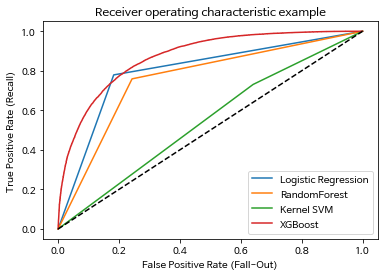

Wall time: 1min 38s


In [51]:
%%time
Make_Roc_Curve(test_vecs_w2v, y_test, classifier, classifier2, classifier3, gbm)

In [52]:
del classifier
del classifier2
del classifier3
del gbm

## Neural Network

In [22]:
with K.tf.device('/gpu:0'):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=1000))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0,
              validation_split=0.2,
              callbacks=[TQDMNotebookCallback(show_inner=False)])

    score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
    print('Score: %1.4f' % score)
    print('Accuracy: %1.4f' % acc)
    model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4771
Accuracy: 0.7980


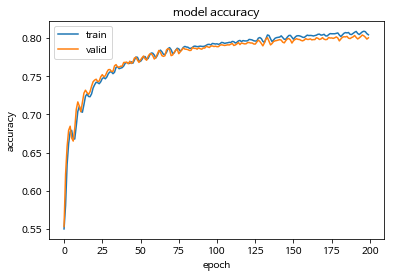

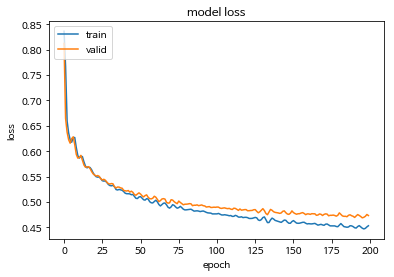

In [23]:
plot_history(history)

In [24]:
with K.tf.device('/gpu:0'):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=1000))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adadelta',
        loss='binary_crossentropy',
        metrics=['accuracy'])

    history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0, validation_split=0.2,
              callbacks=[TQDMNotebookCallback(show_inner=False)])
    score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
    print('Score: %1.4f' % score)
    print('Accuracy: %1.4f' % acc)
    model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4649
Accuracy: 0.8070


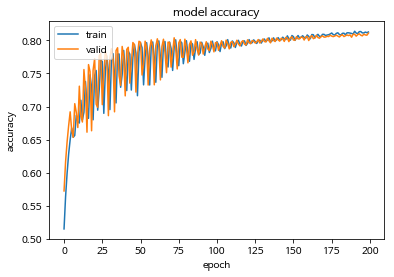

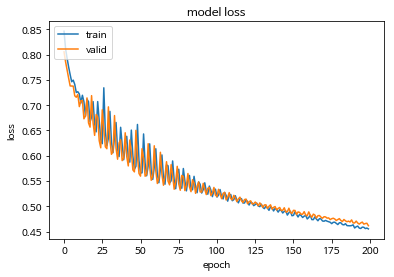

In [25]:
plot_history(history)

In [26]:
del model1
del wv1
del train_vecs_w2v
del test_vecs_w2v

### Model_2 

In [27]:
print ('Load Model2')
model2 = FastText.load(loadModelPath+'fastText_size-1000_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-0_cbow_mean-1_min_count-2_by-mecab.model')

Load Model2


In [28]:
wv1, train_vecs_w2v, test_vecs_w2v = Make_Pre_Data(model2, tfidf, 1000, train, test)
modelName = Return_ModelName(model2,'mecab')

FastText(vocab=165823, size=1000, alpha=0.025)


  0%|          | 0/165823 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 165823/165823 [00:20<00:00, 8140.83it/s]


running time : 0:00:40.654228
Vectorizing Train Data


0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
442359it [19:06, 385.95it/s]


scaling Train Data
running time : 0:24:03.754890
Vectorizing Test Data


49151it [06:22, 128.38it/s]


scaling Test Data
running time : 0:06:29.635336
total running time : 0:31:14.044454


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  if __name__ == '__main__':


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [29]:
%%time
Make_TSNE2(2, model2, wv1, 10000)

Loading BokehJS ...

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
100%|██████████| 10000/10000 [00:00<00:00, 25512.77it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.726s...
[t-SNE] Computed neighbors for 10000 samples in 162.784s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.307782
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.816376
[t-SNE] Error after 1000 iterations: 2.574254


#### 분류모델 : Logistic Regression

In [30]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

Wall time: 7min 17s


C:\Users\pc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 12, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8176028971943602
classification report
             precision    recall  f1-score   support

          0       0.82      0.83      0.83     25350
          1       0.82      0.80      0.81     23801

avg / total       0.82      0.82      0.82     49151

Wall time: 7min 14s


#### 분류모델 : Random Forest

In [31]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 12, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8039103985676792
classification report
             precision    recall  f1-score   support

          0       0.81      0.80      0.81     25350
          1       0.79      0.80      0.80     23801

avg / total       0.80      0.80      0.80     49151

Wall time: 4min 45s


#### 분류모델 : C - Support Vector Classification

In [32]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_vecs_w2v)
train_vecs_w2v2 = scaling.transform(train_vecs_w2v)
test_vecs_w2v2 = scaling.transform(test_vecs_w2v)
classifier3 =  SVC(kernel = 'linear',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v2)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.494659315171614
classification report
             precision    recall  f1-score   support

          0       0.81      0.03      0.05     25350
          1       0.49      0.99      0.66     23801

avg / total       0.65      0.49      0.34     49151

Wall time: 23min 10s


#### 분류모델 : XGBOOST

In [33]:
max_depth = 5
subsample = 0.7
colsample_bytree= 0.7
params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
    'eta':0.125,
    'nthread' : cores
    
    }
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

In [34]:
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [35]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
print (accuracy_score(y_test, test_class))
print (classification_report(y_test, test_class))
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-auc:0.736058	eval-auc:0.731072
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.772571	eval-auc:0.768634
[2]	train-auc:0.787193	eval-auc:0.782912
[3]	train-auc:0.794905	eval-auc:0.790541
[4]	train-auc:0.800108	eval-auc:0.795855
[5]	train-auc:0.806483	eval-auc:0.802361
[6]	train-auc:0.811456	eval-auc:0.807096
[7]	train-auc:0.816727	eval-auc:0.811954
[8]	train-auc:0.819455	eval-auc:0.814393
[9]	train-auc:0.821956	eval-auc:0.816966
[10]	train-auc:0.824656	eval-auc:0.81951
[11]	train-auc:0.827922	eval-auc:0.823025
[12]	train-auc:0.831149	eval-auc:0.826337
[13]	train-auc:0.833582	eval-auc:0.828559
[14]	train-auc:0.835954	eval-auc:0.830821
[15]	train-auc:0.838391	eval-auc:0.833091
[16]	train-auc:0.841035	eval-auc:0.835421
[17]	train-auc:0.843292	eval-auc:0.837663
[18]	train-auc:0.845242	eval-auc:0.839464
[19]	train-auc:0.846812	eval-auc:0.841148
[20]	train-auc:0.848536	eval-a

[191]	train-auc:0.921178	eval-auc:0.905874
[192]	train-auc:0.92133	eval-auc:0.905958
[193]	train-auc:0.921472	eval-auc:0.906078
[194]	train-auc:0.921612	eval-auc:0.906175
[195]	train-auc:0.921739	eval-auc:0.906247
[196]	train-auc:0.921893	eval-auc:0.906388
[197]	train-auc:0.922036	eval-auc:0.906476
[198]	train-auc:0.922184	eval-auc:0.906549
[199]	train-auc:0.922345	eval-auc:0.906648
0.8242151736485525
             precision    recall  f1-score   support

          0       0.83      0.83      0.83     25350
          1       0.82      0.82      0.82     23801

avg / total       0.82      0.82      0.82     49151



Logistic Regression
Random Forest
Kernel SVM
XGBoost


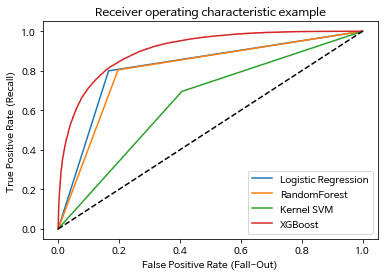

Wall time: 2min 18s


In [36]:
%%time
Make_Roc_Curve(test_vecs_w2v, y_test, classifier, classifier2, classifier3, gbm)

In [37]:
del classifier
del classifier2
del classifier3
del gbm

## Neural Network

In [38]:
with K.tf.device('/gpu:0'):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=1000))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0,
              validation_split=0.2,
              callbacks=[TQDMNotebookCallback(show_inner=False)])

    score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
    print('Score: %1.4f' % score)
    print('Accuracy: %1.4f' % acc)
    model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.3967
Accuracy: 0.8350


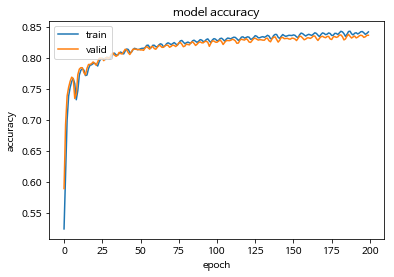

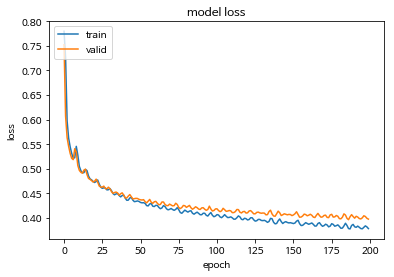

In [39]:
plot_history(history)

In [40]:
with K.tf.device('/gpu:0'):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=1000))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adadelta',
        loss='binary_crossentropy',
        metrics=['accuracy'])

    history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0, validation_split=0.2,
              callbacks=[TQDMNotebookCallback(show_inner=False)])
    score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
    print('Score: %1.4f' % score)
    print('Accuracy: %1.4f' % acc)
    model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))


Score: 0.4230
Accuracy: 0.8294


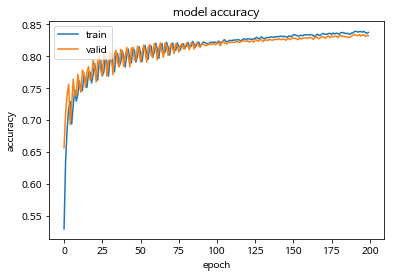

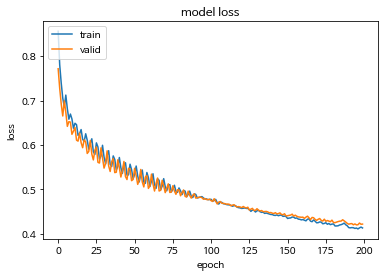

In [41]:
plot_history(history)

In [42]:
del model2
del wv1
del train_vecs_w2v
del test_vecs_w2v

### Model_3

In [15]:
print ('Load Model3')
model3 = FastText.load(loadModelPath+'fastText_size-1000_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-1_cbow_mean-0_min_count-2_by-mecab.model')

Load Model3


In [ ]:
wv1, train_vecs_w2v, test_vecs_w2v = Make_Pre_Data(model3, tfidf, 1000, train, test)
modelName = Return_ModelName(model3,'mecab')

FastText(vocab=165823, size=1000, alpha=0.025)


  0%|          | 0/165823 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
100%|██████████| 165823/165823 [00:01<00:00, 85642.29it/s]


running time : 0:00:01.940235
Vectorizing Train Data


0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
20653it [02:11, 156.60it/s]

#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [ ]:
%%time
Make_TSNE2(2, model3, wv1, 10000)

#### 분류모델 : Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

#### 분류모델 : Random Forest

In [ ]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

#### 분류모델 : C - Support Vector Classification

In [ ]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_vecs_w2v)
train_vecs_w2v2 = scaling.transform(train_vecs_w2v)
test_vecs_w2v2 = scaling.transform(test_vecs_w2v)
classifier3 =  SVC(kernel = 'linear',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v2)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

#### 분류모델 : XGBOOST

In [ ]:
max_depth = 5
subsample = 0.7
colsample_bytree= 0.7
params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
    'eta':0.125,
    'nthread' : cores
    
    }
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

In [ ]:
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [ ]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_class = np.round(test_prediction)
print (accuracy_score(y_test, test_class))
print (classification_report(y_test, test_class))
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

In [ ]:
%%time
Make_Roc_Curve(test_vecs_w2v, y_test, classifier, classifier2, classifier3, gbm)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

## Neural Network

In [ ]:
with K.tf.device('/gpu:0'):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=1000))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0,
              validation_split=0.2,
              callbacks=[TQDMNotebookCallback(show_inner=False)])

    score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
    print('Score: %1.4f' % score)
    print('Accuracy: %1.4f' % acc)
    model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

In [ ]:
plot_history(history)

In [ ]:
with K.tf.device('/gpu:0'):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=1000))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adadelta',
        loss='binary_crossentropy',
        metrics=['accuracy'])

    history = model.fit(train_vecs_w2v, y_train, epochs=200, batch_size = 200000, verbose=0, validation_split=0.2,
              callbacks=[TQDMNotebookCallback(show_inner=False)])
    score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
    print('Score: %1.4f' % score)
    print('Accuracy: %1.4f' % acc)
    model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

In [ ]:
plot_history(history)

In [ ]:
del model3
del wv1
del train_vecs_w2v
del test_vecs_w2v